# VAR(MA) Exercise

Roadmap for VAR(MA) analysis

### 1. Get dataset

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')

In [82]:
df1 = pd.read_csv('CIVPART.csv')
df2 = pd.read_csv('CPALTT01USM661S.csv')
df3 = pd.read_csv('M2SL.csv')
df4 = pd.read_csv('PCE.csv')
df5 = pd.read_csv('USPHCI.csv')

In [83]:
for df in [df1, df2, df3, df4, df5]:
    df['DATE'] = pd.to_datetime(df['DATE'])

In [84]:
df = pd.merge(df1, df2, on='DATE')
df = pd.merge(df, df3, on='DATE')
df = pd.merge(df, df4, on='DATE')
df = pd.merge(df, df5, on='DATE')

# Set DATE as the index
df.set_index('DATE', inplace=True)

In [85]:
df.head()

,CIVPART,CPALTT01USM661S,M2SL,PCE,USPHCI
DATE,,,,,
1979-01-01,63.6,28.900881,1371.6,1502.4,45.68
1979-02-01,63.8,29.196218,1377.8,1517.8,45.83
1979-03-01,63.8,29.491555,1387.8,1531.2,46.07
1979-04-01,63.5,29.786893,1402.1,1538.4,46.15
1979-05-01,63.3,30.124421,1410.2,1558.8,46.38


In [86]:
df.tail()

,CIVPART,CPALTT01USM661S,M2SL,PCE,USPHCI
DATE,,,,,
2022-11-01,62.2,125.981681,21398.7,17735.0,135.86
2022-12-01,62.3,126.147070,21358.1,17736.5,136.27
2023-01-01,62.4,126.799344,21212.6,18078.7,136.77
2023-02-01,62.5,127.268508,21076.9,18101.5,137.00
2023-03-01,62.6,127.336014,20840.3,18116.0,137.38


In [87]:
start_date = '1979-01-01'
end_date = '2020-02-01'

df_og = df
df = df[start_date:end_date]

In [88]:
df.head()

,CIVPART,CPALTT01USM661S,M2SL,PCE,USPHCI
DATE,,,,,
1979-01-01,63.6,28.900881,1371.6,1502.4,45.68
1979-02-01,63.8,29.196218,1377.8,1517.8,45.83
1979-03-01,63.8,29.491555,1387.8,1531.2,46.07
1979-04-01,63.5,29.786893,1402.1,1538.4,46.15
1979-05-01,63.3,30.124421,1410.2,1558.8,46.38


In [89]:
df.tail()

,CIVPART,CPALTT01USM661S,M2SL,PCE,USPHCI
DATE,,,,,
2019-10-01,63.3,108.533987,15140.8,14554.2,128.41
2019-11-01,63.3,108.769835,15242.2,14613.8,128.68
2019-12-01,63.3,109.112848,15320.7,14689.2,128.92
2020-01-01,63.3,109.290473,15396.0,14728.8,129.32
2020-02-01,63.3,109.379496,15450.3,14785.7,129.70


In [90]:
df.columns

Index(['CIVPART', 'CPALTT01USM661S', 'M2SL', 'PCE', 'USPHCI'], dtype='object')

In [91]:
df.rename(columns={
    'CIVPART': 'LaborForceParticipationRate',
    'CPALTT01USM661S': 'ConsumerPriceIndex',
    'M2SL': 'MoneyStock',
    'PCE': 'PersonalConsumptionExpenditures',
    'USPHCI': 'CoincidentEconomicActivityIndex'
}, inplace=True)

In [92]:
df

,LaborForceParticipationRate,ConsumerPriceIndex,MoneyStock,PersonalConsumptionExpenditures,CoincidentEconomicActivityIndex
DATE,,,,,
1979-01-01,63.6,28.900881,1371.6,1502.4,45.68
1979-02-01,63.8,29.196218,1377.8,1517.8,45.83
1979-03-01,63.8,29.491555,1387.8,1531.2,46.07
1979-04-01,63.5,29.786893,1402.1,1538.4,46.15
1979-05-01,63.3,30.124421,1410.2,1558.8,46.38
...,...,...,...,...,...
2019-10-01,63.3,108.533987,15140.8,14554.2,128.41
2019-11-01,63.3,108.769835,15242.2,14613.8,128.68
2019-12-01,63.3,109.112848,15320.7,14689.2,128.92


In [93]:
df.index

DatetimeIndex(['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01',
               ...
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01'],
              dtype='datetime64[ns]', name='DATE', length=494, freq=None)

In [94]:
df = df.asfreq('MS')

In [95]:
df.index

DatetimeIndex(['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01',
               ...
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01'],
              dtype='datetime64[ns]', name='DATE', length=494, freq='MS')

### 2. Check dataset

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 1979-01-01 to 2020-02-01
Freq: MS
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   LaborForceParticipationRate      494 non-null    float64
 1   ConsumerPriceIndex               494 non-null    float64
 2   MoneyStock                       494 non-null    float64
 3   PersonalConsumptionExpenditures  494 non-null    float64
 4   CoincidentEconomicActivityIndex  494 non-null    float64
dtypes: float64(5)
memory usage: 23.2 KB


In [97]:
df.describe()

,LaborForceParticipationRate,ConsumerPriceIndex,MoneyStock,PersonalConsumptionExpenditures,CoincidentEconomicActivityIndex
count,494.000000,494.000000,494.000000,494.000000,494.000000
mean,65.203239,71.419925,5979.592915,6942.206680,82.070628
std,1.475228,22.262776,3866.593027,3841.235435,23.756492
min,62.400000,28.900881,1371.600000,1502.400000,45.680000
25%,63.800000,52.000489,3007.400000,3545.200000,62.320000
50%,65.800000,70.416890,4543.100000,6309.750000,84.770000
75%,66.475000,91.695005,8467.850000,10128.325000,99.745000
max,67.300000,109.379496,15450.300000,14785.700000,129.700000


In [98]:
df.head()

,LaborForceParticipationRate,ConsumerPriceIndex,MoneyStock,PersonalConsumptionExpenditures,CoincidentEconomicActivityIndex
DATE,,,,,
1979-01-01,63.6,28.900881,1371.6,1502.4,45.68
1979-02-01,63.8,29.196218,1377.8,1517.8,45.83
1979-03-01,63.8,29.491555,1387.8,1531.2,46.07
1979-04-01,63.5,29.786893,1402.1,1538.4,46.15
1979-05-01,63.3,30.124421,1410.2,1558.8,46.38


In [99]:
df.tail()

,LaborForceParticipationRate,ConsumerPriceIndex,MoneyStock,PersonalConsumptionExpenditures,CoincidentEconomicActivityIndex
DATE,,,,,
2019-10-01,63.3,108.533987,15140.8,14554.2,128.41
2019-11-01,63.3,108.769835,15242.2,14613.8,128.68
2019-12-01,63.3,109.112848,15320.7,14689.2,128.92
2020-01-01,63.3,109.290473,15396.0,14728.8,129.32
2020-02-01,63.3,109.379496,15450.3,14785.7,129.70


### 3. Exploratory data analysis

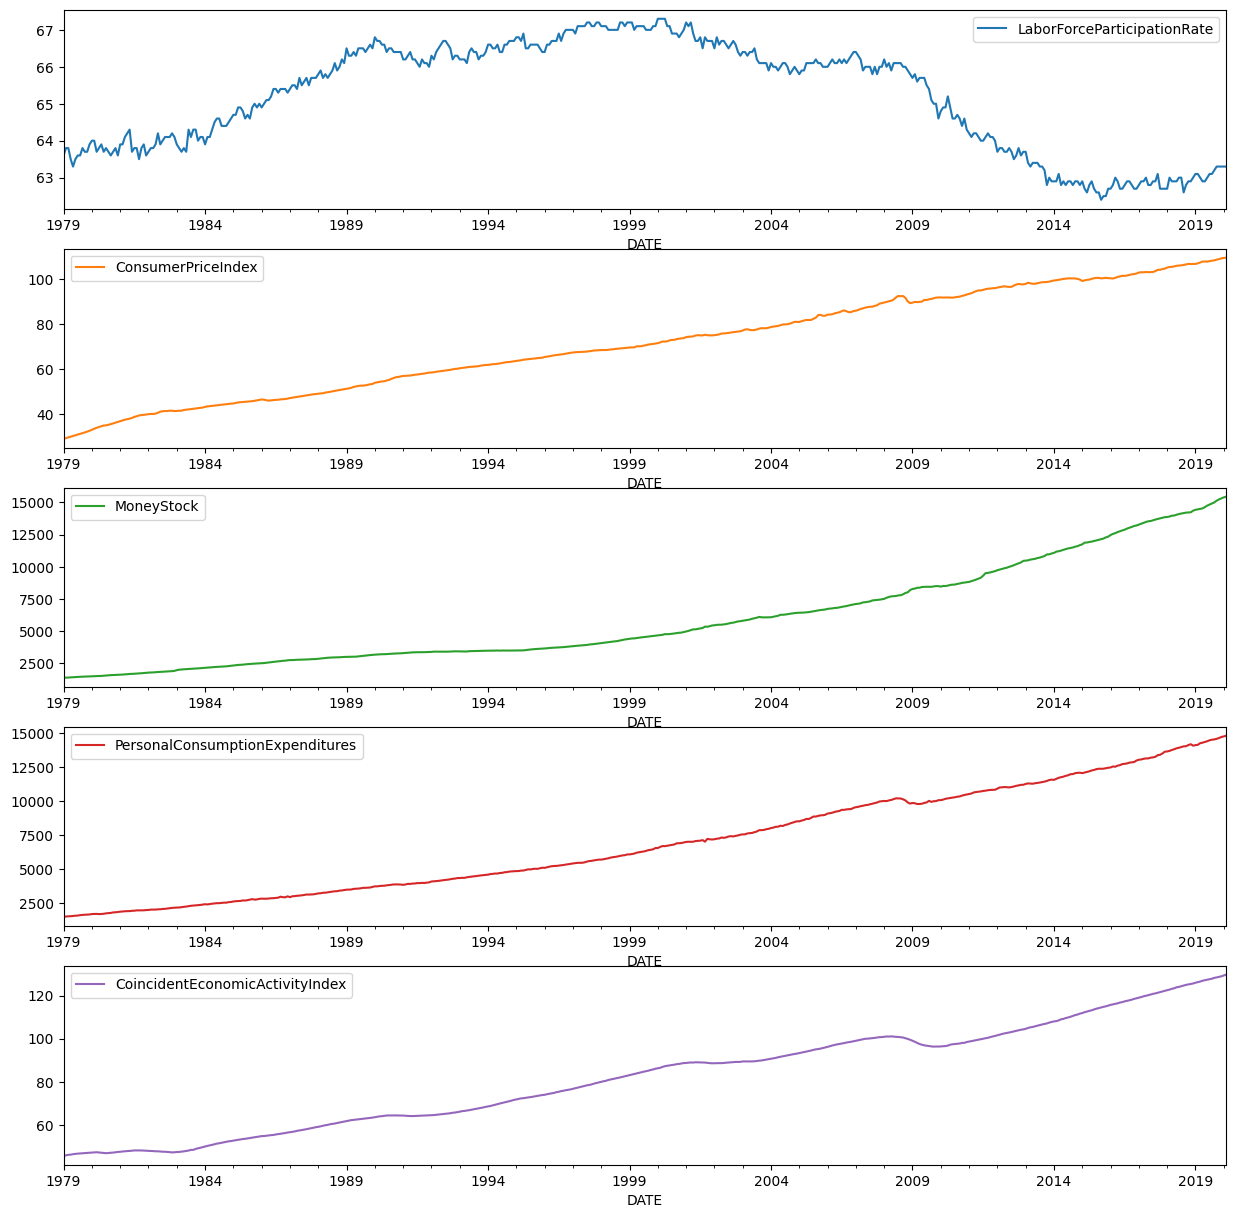

In [100]:
df.plot(subplots=True, layout=(5, -1), figsize=(15, 15), sharex=False);

<Axes: title={'center': 'Correlation map\n'}>

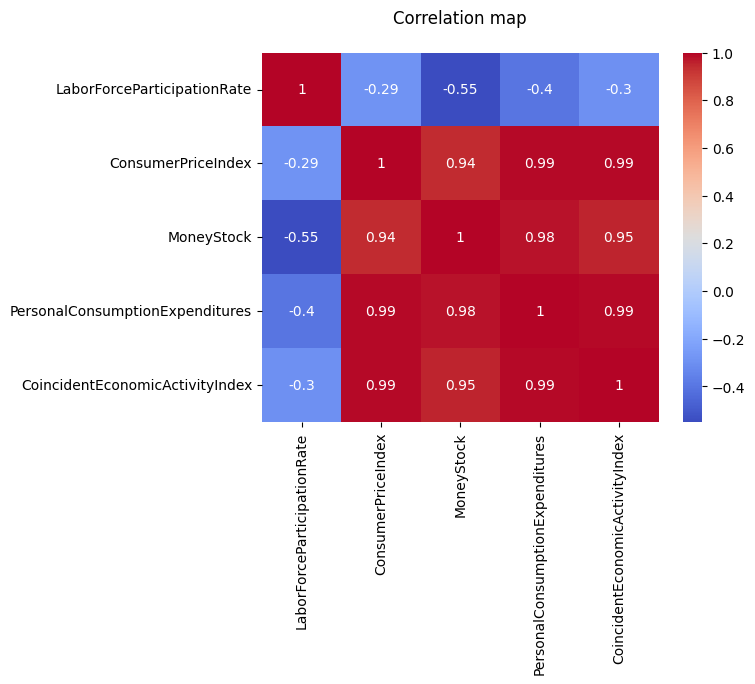

In [101]:
plt.title('Correlation map\n')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

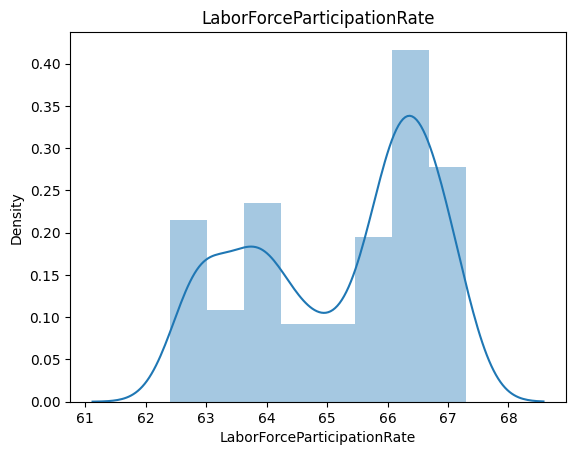

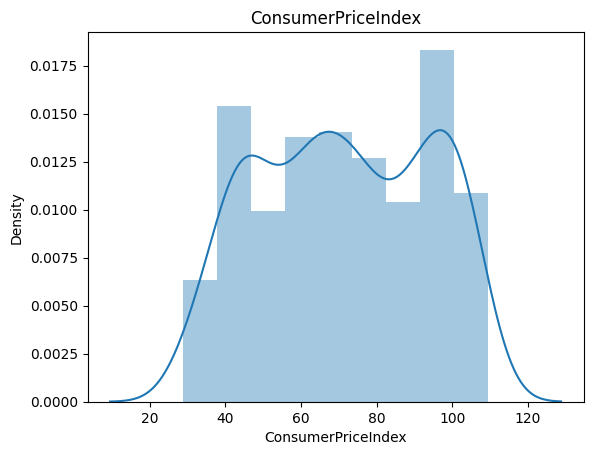

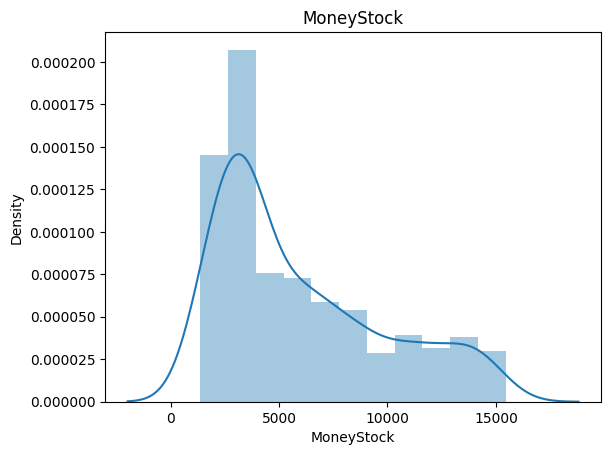

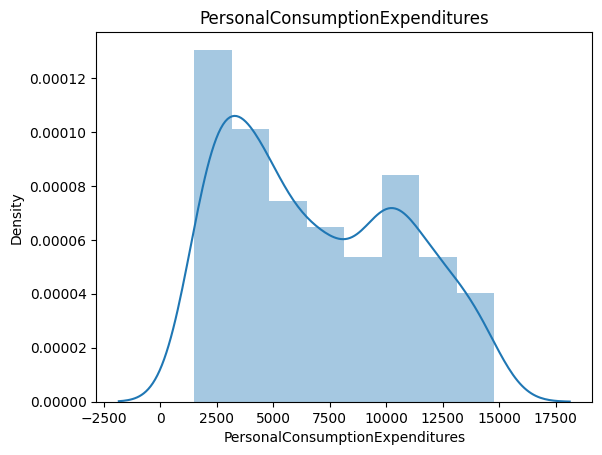

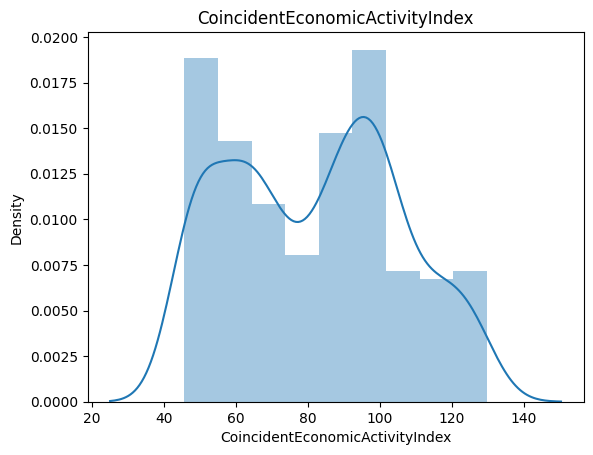

In [102]:
for column in df.columns:
    plt.title(column)
    sns.distplot(df[column])
    plt.show()

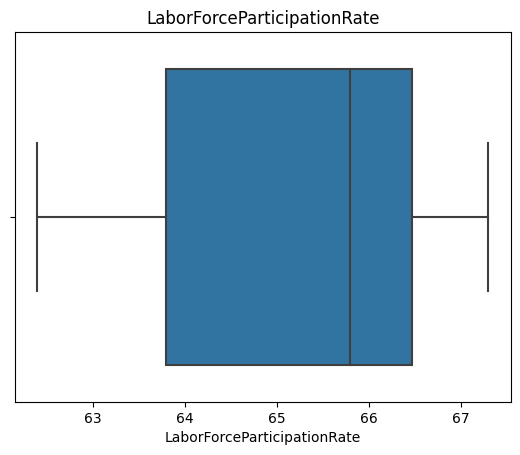

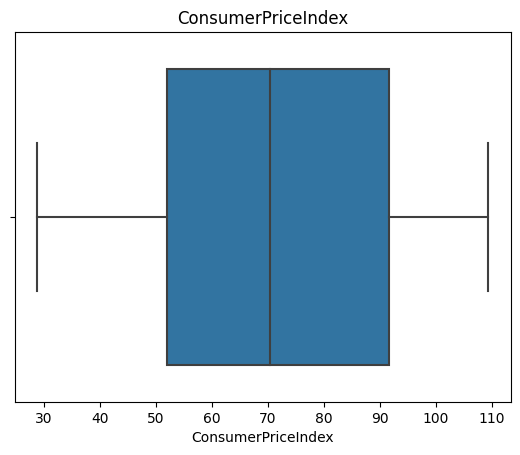

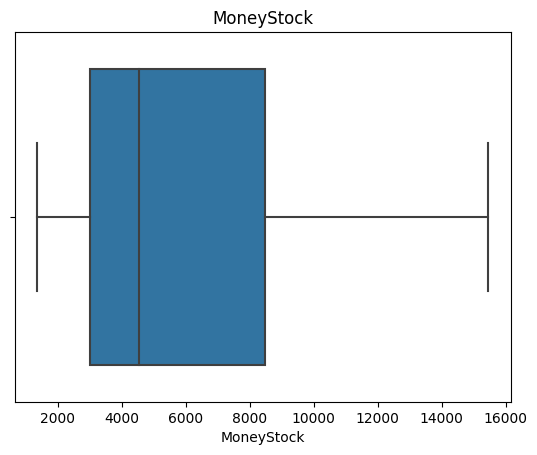

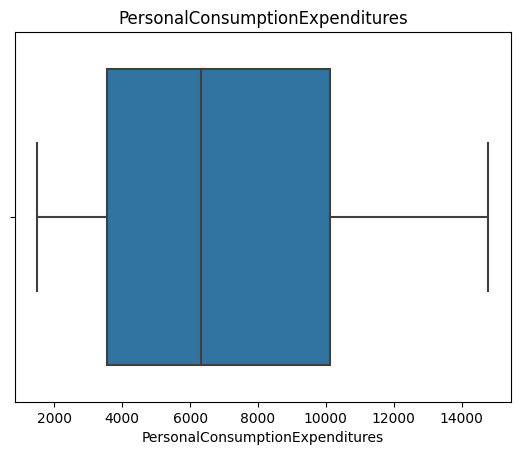

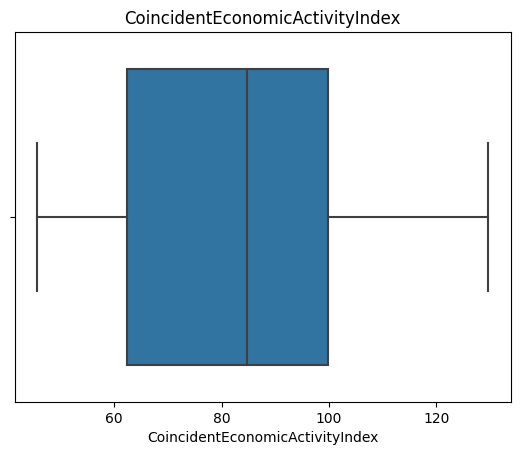

In [103]:
for column in df.columns:
    plt.title(column)
    sns.boxplot(data=df, x=column)
    plt.show()

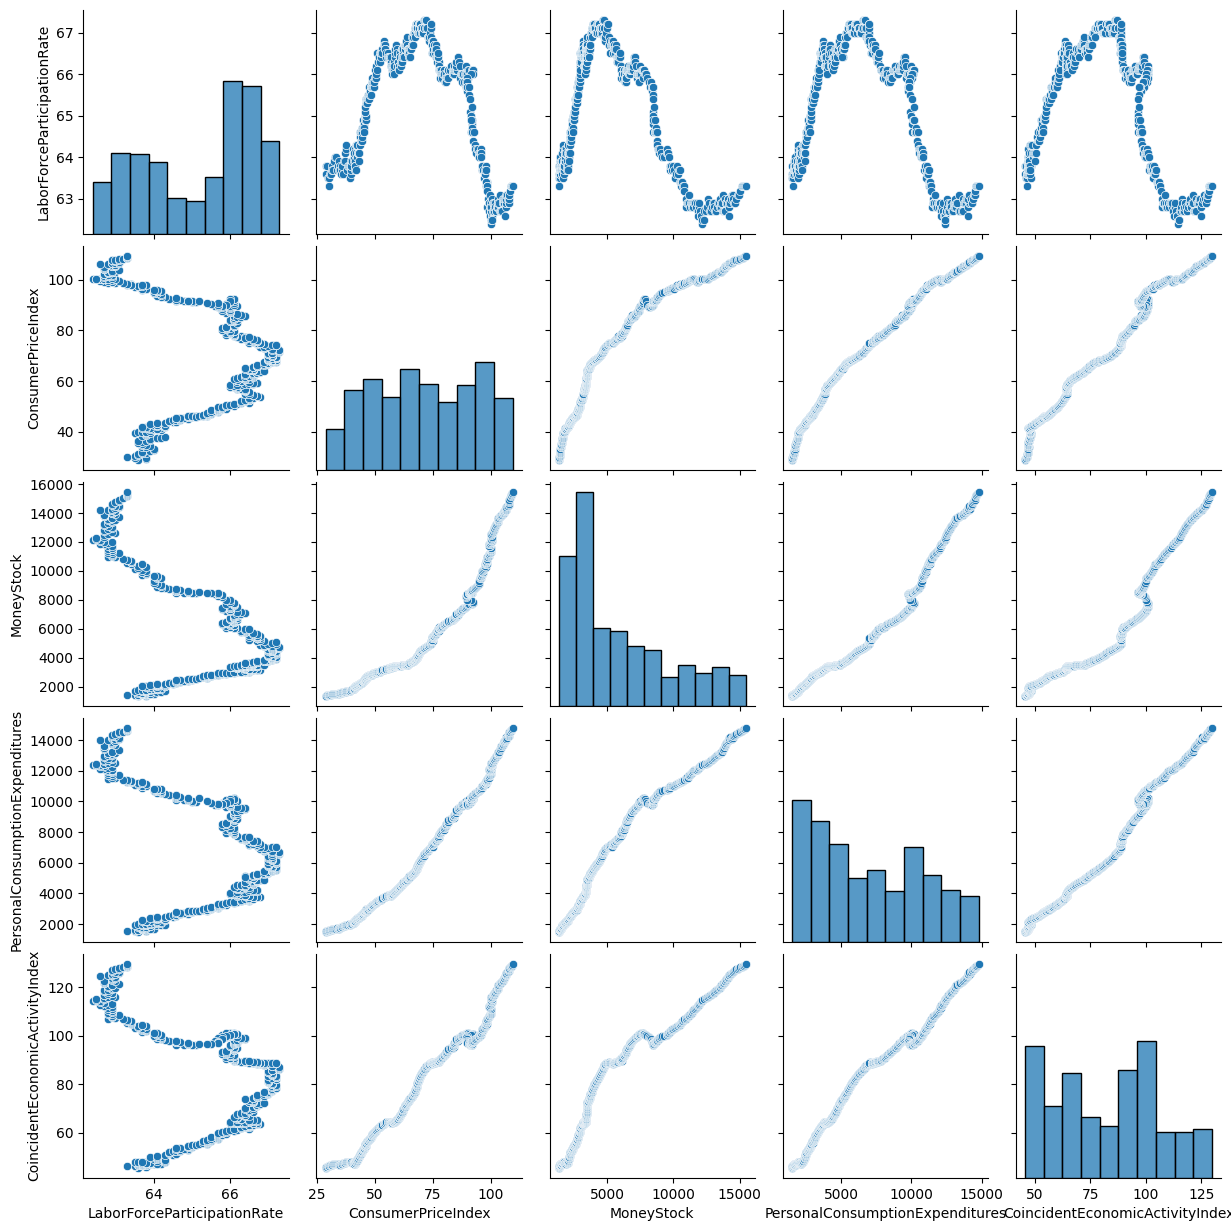

In [104]:
sns.pairplot(df)

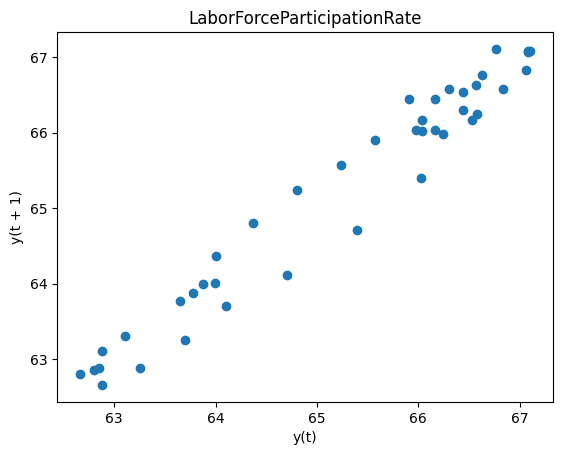

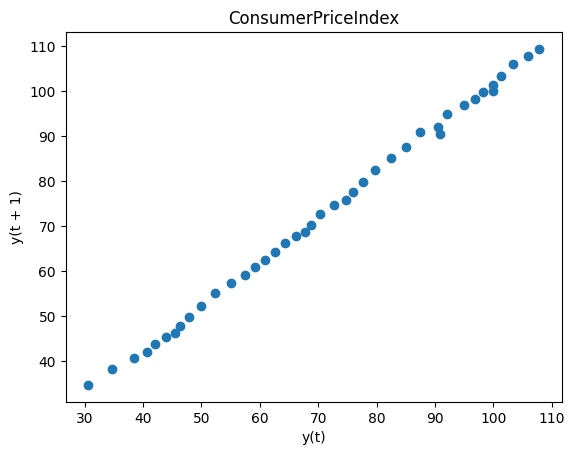

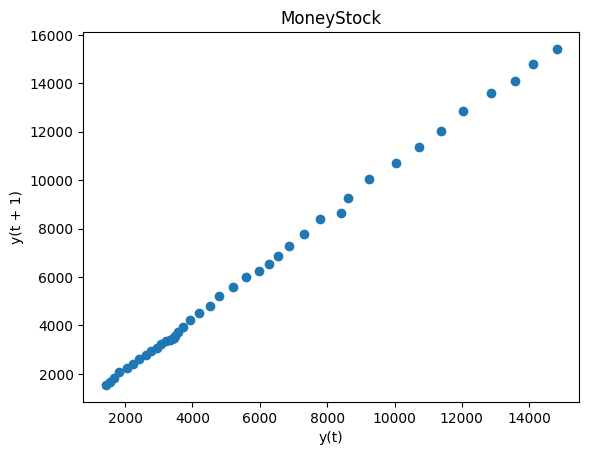

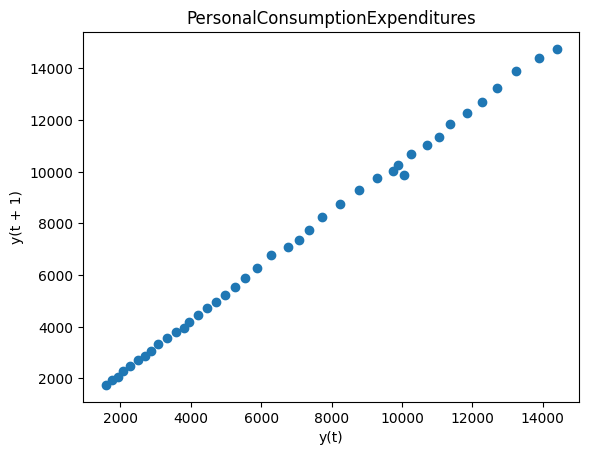

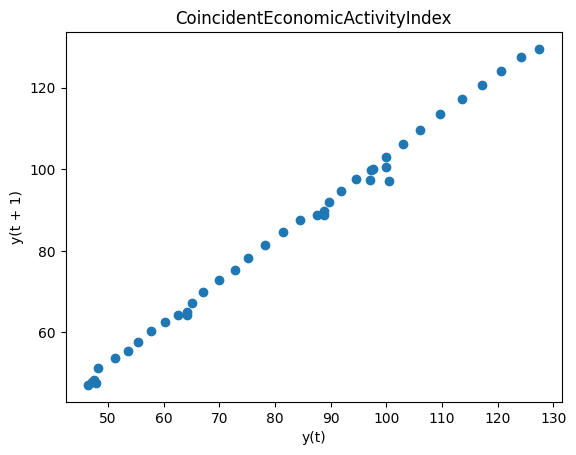

In [105]:
for column in df.columns:
    plt.title(column)
    pd.plotting.lag_plot(df[column].resample('Y').mean())
    plt.show()

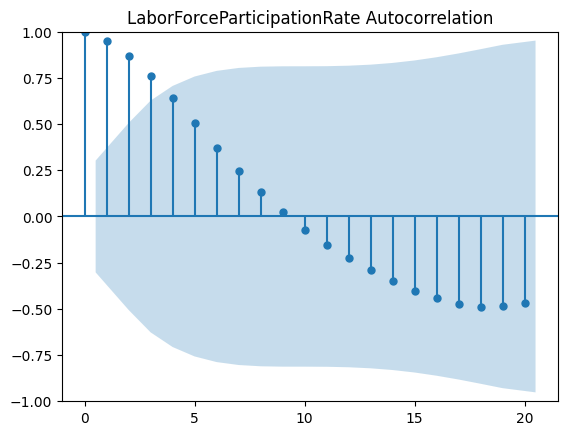

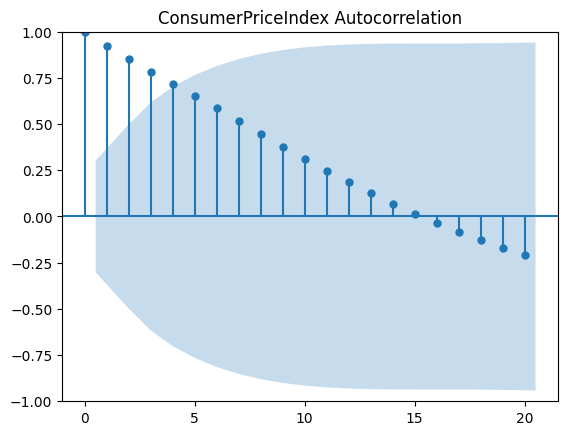

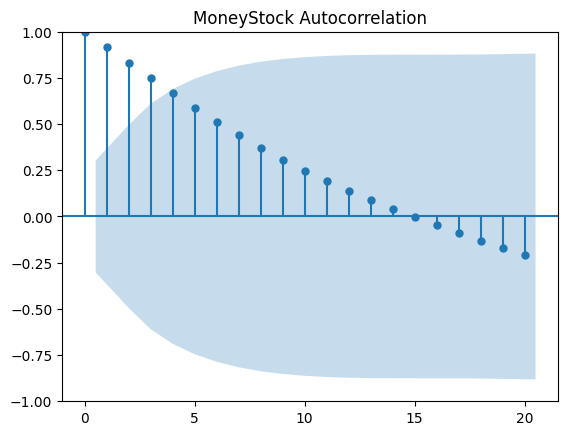

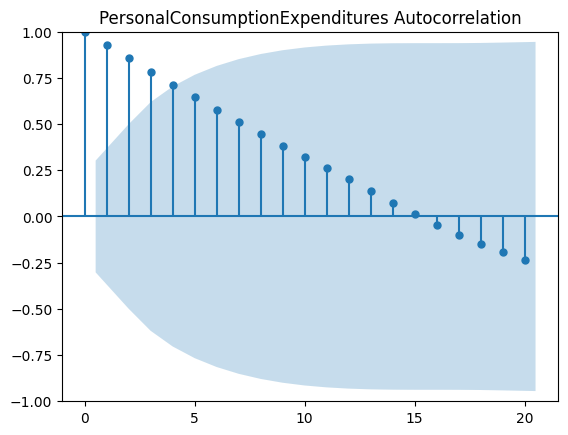

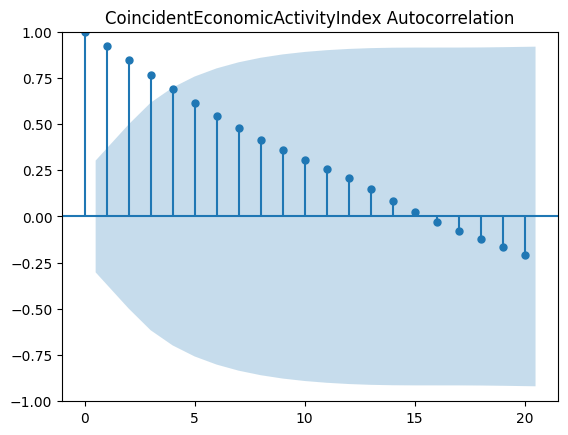

In [106]:
for column in df.columns:
    plot_acf(df[column].resample('Y').mean(), lags=20, title=column + ' Autocorrelation')
    plt.show()

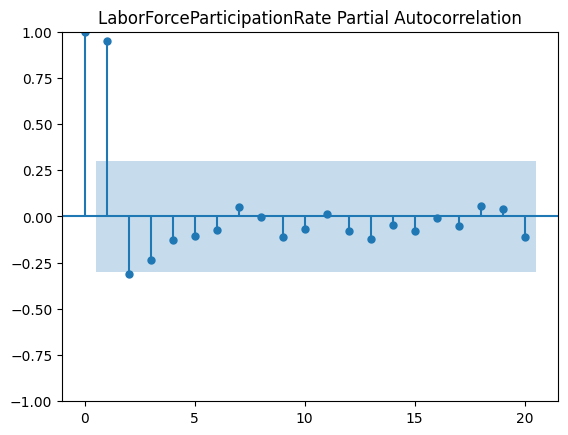

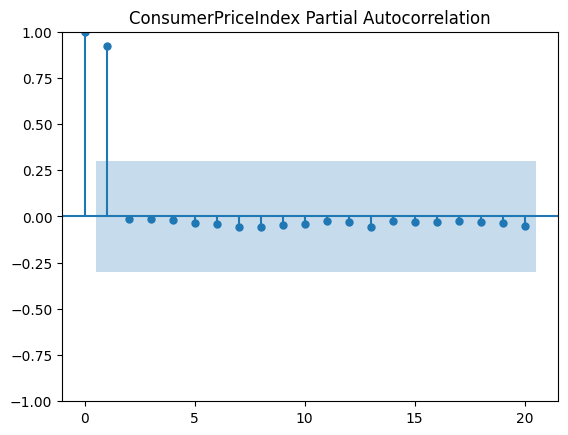

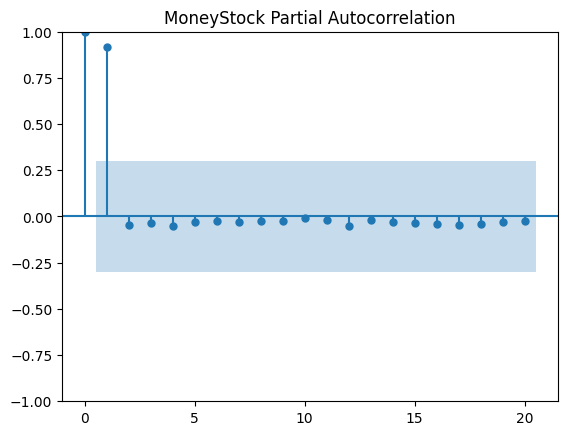

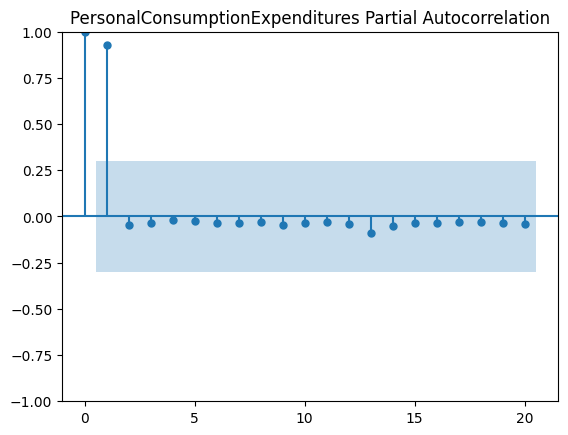

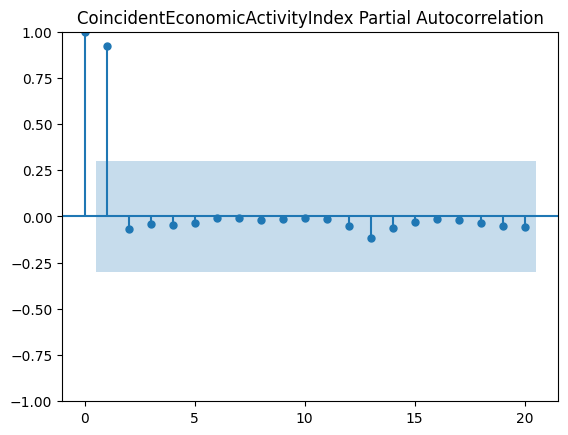

In [107]:
for column in df.columns:
    plot_pacf(df[column].resample('Y').mean(), lags=20, title=column + ' Partial Autocorrelation')
    plt.show()

### 4. Check stationarity

In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
def kpss_test(series,title=''):
    print(f'KPSS Test: {title}')
    statistic, p_value, n_lags, critical_values = kpss(series, regression='c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'P-Value: {p_value}')
    print(f'Number of Lags Used: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

    alpha = 0.05
    if p_value > alpha:
        print('The null hypothesis cannot be rejected (The series is stationary)')
    else:
        print('The null hypothesis can be rejected (The series is not stationary)')

In [110]:
df_var = df[['LaborForceParticipationRate', 'CoincidentEconomicActivityIndex']]

In [111]:
df_var.head()

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
DATE,,
1979-01-01,63.6,45.68
1979-02-01,63.8,45.83
1979-03-01,63.8,46.07
1979-04-01,63.5,46.15
1979-05-01,63.3,46.38


In [112]:
df_var.columns

Index(['LaborForceParticipationRate', 'CoincidentEconomicActivityIndex'], dtype='object')

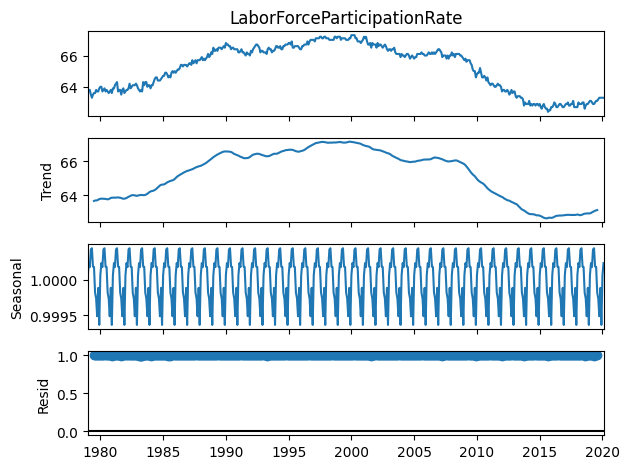

In [113]:
labforce_mult = seasonal_decompose(df_var['LaborForceParticipationRate'], model='multiplicative')
labforce_mult.plot();

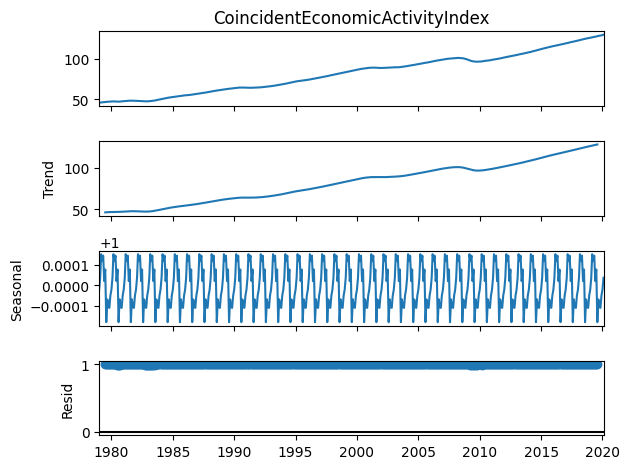

In [114]:
econindex_mult = seasonal_decompose(df_var['CoincidentEconomicActivityIndex'], model='multiplicative')
econindex_mult.plot();

In [115]:
for column in df_var:
    print(f"\nTesting: {column}\n")
    
    print("Performing ADF Test:")
    adf_test(df[column], title=column)
    
    print("\nPerforming KPSS Test:")
    kpss_test(df[column], title=column)
    
    print("\nPerforming Phillips-Perron Test:")
    pp_test = PhillipsPerron(df[column])
    print(pp_test.summary())


Testing: LaborForceParticipationRate

Performing ADF Test:
Augmented Dickey-Fuller Test: LaborForceParticipationRate
ADF test statistic       -0.532236
p-value                   0.885571
# lags used               5.000000
# observations          488.000000
critical value (1%)      -3.443821
critical value (5%)      -2.867481
critical value (10%)     -2.569934
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Performing KPSS Test:
KPSS Test: LaborForceParticipationRate
KPSS Statistic: 1.208927066213023
P-Value: 0.01
Number of Lags Used: 12
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The null hypothesis can be rejected (The series is not stationary)

Performing Phillips-Perron Test:
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.743
P-value                         0.835
Lags                               18
-------------------------------------

Trend: Constant

### 5. Differencing

In [116]:
df_diff = df_var.diff()

In [117]:
df_diff.head()

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
DATE,,
1979-01-01,NaN,NaN
1979-02-01,0.2,0.15
1979-03-01,0.0,0.24
1979-04-01,-0.3,0.08
1979-05-01,-0.2,0.23


In [118]:
df_diff = df_diff.dropna()

In [119]:
df_diff.isna().sum()

LaborForceParticipationRate        0
CoincidentEconomicActivityIndex    0
dtype: int64

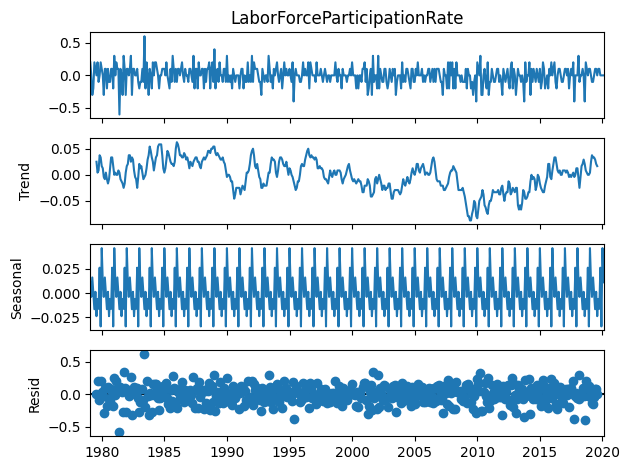

In [120]:
labforce_diff_add = seasonal_decompose(df_diff['LaborForceParticipationRate'], model='additive')
labforce_diff_add.plot();

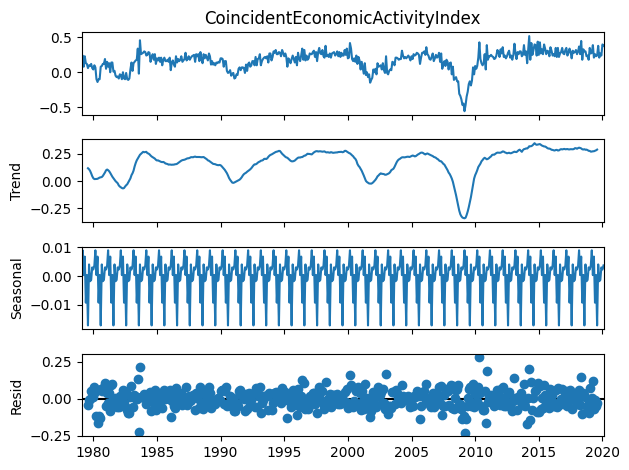

In [121]:
econindex_diff_add = seasonal_decompose(df_diff['CoincidentEconomicActivityIndex'], model='additive')
econindex_diff_add.plot();

In [126]:
for column in df_diff:
    print(f"\nTesting: {column}\n")
    
    print("Performing ADF Test:")
    adf_test(df_diff[column], title=column)
    
    print("\nPerforming KPSS Test:")
    kpss_test(df_diff[column], title=column)
    
    print("\nPerforming Phillips-Perron Test:")
    pp_test = PhillipsPerron(df_diff[column])
    print(pp_test.summary())


Testing: LaborForceParticipationRate

Performing ADF Test:
Augmented Dickey-Fuller Test: LaborForceParticipationRate
ADF test statistic     -1.233280e+01
p-value                 6.370561e-23
# lags used             4.000000e+00
# observations          4.880000e+02
critical value (1%)    -3.443821e+00
critical value (5%)    -2.867481e+00
critical value (10%)   -2.569934e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Performing KPSS Test:
KPSS Test: LaborForceParticipationRate
KPSS Statistic: 0.8519752402356009
P-Value: 0.01
Number of Lags Used: 4
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The null hypothesis can be rejected (The series is not stationary)

Performing Phillips-Perron Test:
     Phillips-Perron Test (Z-tau)    
Test Statistic                -28.227
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Con

### 6. Determine VAR order

In [127]:
model = VAR(df_diff)
order = model.select_order(maxlags=12)

In [129]:
order.__dict__

{'title': 'VAR Order Selection (* highlights the minimums)',
 'ics': defaultdict(list,
             {'aic': [-7.747681518332107,
               -8.854857432053038,
               -9.130122839381817,
               -9.160125765605368,
               -9.153467189811861,
               -9.163415730893535,
               -9.15472694447809,
               -9.17330753341308,
               -9.159772564283223,
               -9.146643781492596,
               -9.138033170340718,
               -9.1419899617128,
               -9.1468043514783],
              'bic': [-7.730318244859734,
               -8.802767611635918,
               -9.043306472019951,
               -9.038582851298756,
               -8.997197728560502,
               -8.97241972269743,
               -8.929004389337239,
               -8.912858431327482,
               -8.864596915252879,
               -8.816741585517503,
               -8.77340442742088,
               -8.742634671848217,
               -8.7127225146689

In [130]:
order.summary()

,AIC,BIC,FPE,HQIC
0,-7.748,-7.730,0.0004317,-7.741
1,-8.855,-8.803,0.0001427,-8.834
2,-9.130,-9.043*,0.0001084,-9.096
3,-9.160,-9.039,0.0001052,-9.112*
4,-9.153,-8.997,0.0001059,-9.092
5,-9.163,-8.972,0.0001048,-9.088
6,-9.155,-8.929,0.0001057,-9.066
7,-9.173*,-8.913,0.0001038*,-9.071
8,-9.160,-8.865,0.0001052,-9.044
9,-9.147,-8.817,0.0001066,-9.017


### 7. Split dataset

In [131]:
train = df_diff[:int(0.8*(len(df_diff)))]
test = df_diff[int(0.8*(len(df_diff))):]

### 8. Fit VAR model

In [132]:
order.aic

7

In [133]:
model_fitted = model.fit(maxlags=order.aic)

### 9. Check for serial correlation of residuals/errors

In [149]:
dir(model_fitted)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bmat_forc_cov',
 '_cache',
 '_char_mat',
 '_chol_sigma_u',
 '_cov_alpha',
 '_cov_sigma',
 '_forecast_vars',
 '_model_type',
 '_omega_forc_cov',
 '_zz',
 'acf',
 'acorr',
 'aic',
 'bic',
 'bse',
 'coefs',
 'coefs_exog',
 'cov_params',
 'cov_ybar',
 'dates',
 'detomega',
 'df_model',
 'df_resid',
 'endog',
 'endog_lagged',
 'exog',
 'exog_names',
 'fevd',
 'fittedvalues',
 'forecast',
 'forecast_cov',
 'forecast_interval',
 'fpe',
 'get_eq_index',
 'hqic',
 'info_criteria',
 'intercept',
 'intercept_longrun',
 'irf',
 'irf_errband_mc',
 'irf_resim',
 'is_stable',
 'k_ar',
 'k_exog',
 'k_exog_user',
 'k_tr

In [148]:
model_fitted.params

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
const,-0.021102,0.017433
L1.LaborForceParticipationRate,-0.272516,0.065101
L1.CoincidentEconomicActivityIndex,-0.019519,0.290706
L2.LaborForceParticipationRate,-0.032782,0.029754
L2.CoincidentEconomicActivityIndex,0.143267,0.398628
L3.LaborForceParticipationRate,0.004145,0.047754
L3.CoincidentEconomicActivityIndex,-0.029212,0.244870
L4.LaborForceParticipationRate,-0.127292,-0.001778
L4.CoincidentEconomicActivityIndex,0.004951,0.085807
L5.LaborForceParticipationRate,-0.134927,-0.032584


In [141]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jun, 2023
Time:                     18:59:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.92450
Nobs:                     486.000    HQIC:                  -9.08139
Log likelihood:           882.239    FPE:                0.000102785
AIC:                     -9.18291    Det(Omega_mle):     9.67225e-05
--------------------------------------------------------------------
Results for equation LaborForceParticipationRate
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                     -0.021102         0.010285           -2.052           0.040
L1.LaborForceParticipationRate            -0.272516     

In [135]:
model_fitted.resid

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
DATE,,
1979-09-01,0.127635,-0.029934
1979-10-01,-0.031306,-0.028623
1979-11-01,0.058436,0.001579
1979-12-01,0.214805,-0.024772
1980-01-01,0.165538,-0.049745
...,...,...
2019-10-01,0.141590,-0.077970
2019-11-01,0.018773,0.006721
2019-12-01,0.018060,-0.029845


In [134]:
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

LaborForceParticipationRate : 2.0
ConsumerPriceIndex : 2.01


### 10. Forecast using fitted model

In [150]:
lag_order = model_fitted.k_ar

In [151]:
forecast_input = train.values[-lag_order:]

In [152]:
fc = model_fitted.forecast(y=forecast_input, steps=len(test))

In [154]:
df_forecast = pd.DataFrame(fc, index=test.index, columns=df_diff.columns + '_2d')

In [155]:
df_forecast

,LaborForceParticipationRate_2d,CoincidentEconomicActivityIndex_2d
DATE,,
2011-12-01,0.002273,0.286681
2012-01-01,-0.020181,0.283789
2012-02-01,0.015688,0.283478
2012-03-01,0.021700,0.285747
2012-04-01,0.002886,0.285268
...,...,...
2019-10-01,0.000175,0.178855
2019-11-01,0.000175,0.178852
2019-12-01,0.000174,0.178850


### 11. Inverse differencing

In [165]:
df_forecast['LaborForceParticipationRate'] = df_var['LaborForceParticipationRate'].iloc[-1] + df_forecast['LaborForceParticipationRate_2d'].cumsum()
df_forecast['CoincidentEconomicActivityIndex'] = df_var['CoincidentEconomicActivityIndex'].iloc[-1] + df_forecast['CoincidentEconomicActivityIndex_2d'].cumsum()

In [166]:
df_forecast

,LaborForceParticipationRate_2d,CoincidentEconomicActivityIndex_2d,LaborForceParticipationRate,CoincidentEconomicActivityIndex
DATE,,,,
2011-12-01,0.002273,0.286681,63.302273,129.986681
2012-01-01,-0.020181,0.283789,63.282092,130.270469
2012-02-01,0.015688,0.283478,63.297779,130.553947
2012-03-01,0.021700,0.285747,63.319479,130.839694
2012-04-01,0.002886,0.285268,63.322366,131.124962
...,...,...,...,...
2019-10-01,0.000175,0.178855,63.476766,148.557419
2019-11-01,0.000175,0.178852,63.476940,148.736271
2019-12-01,0.000174,0.178850,63.477115,148.915121


### 12. Plot actual vs. forecasted values

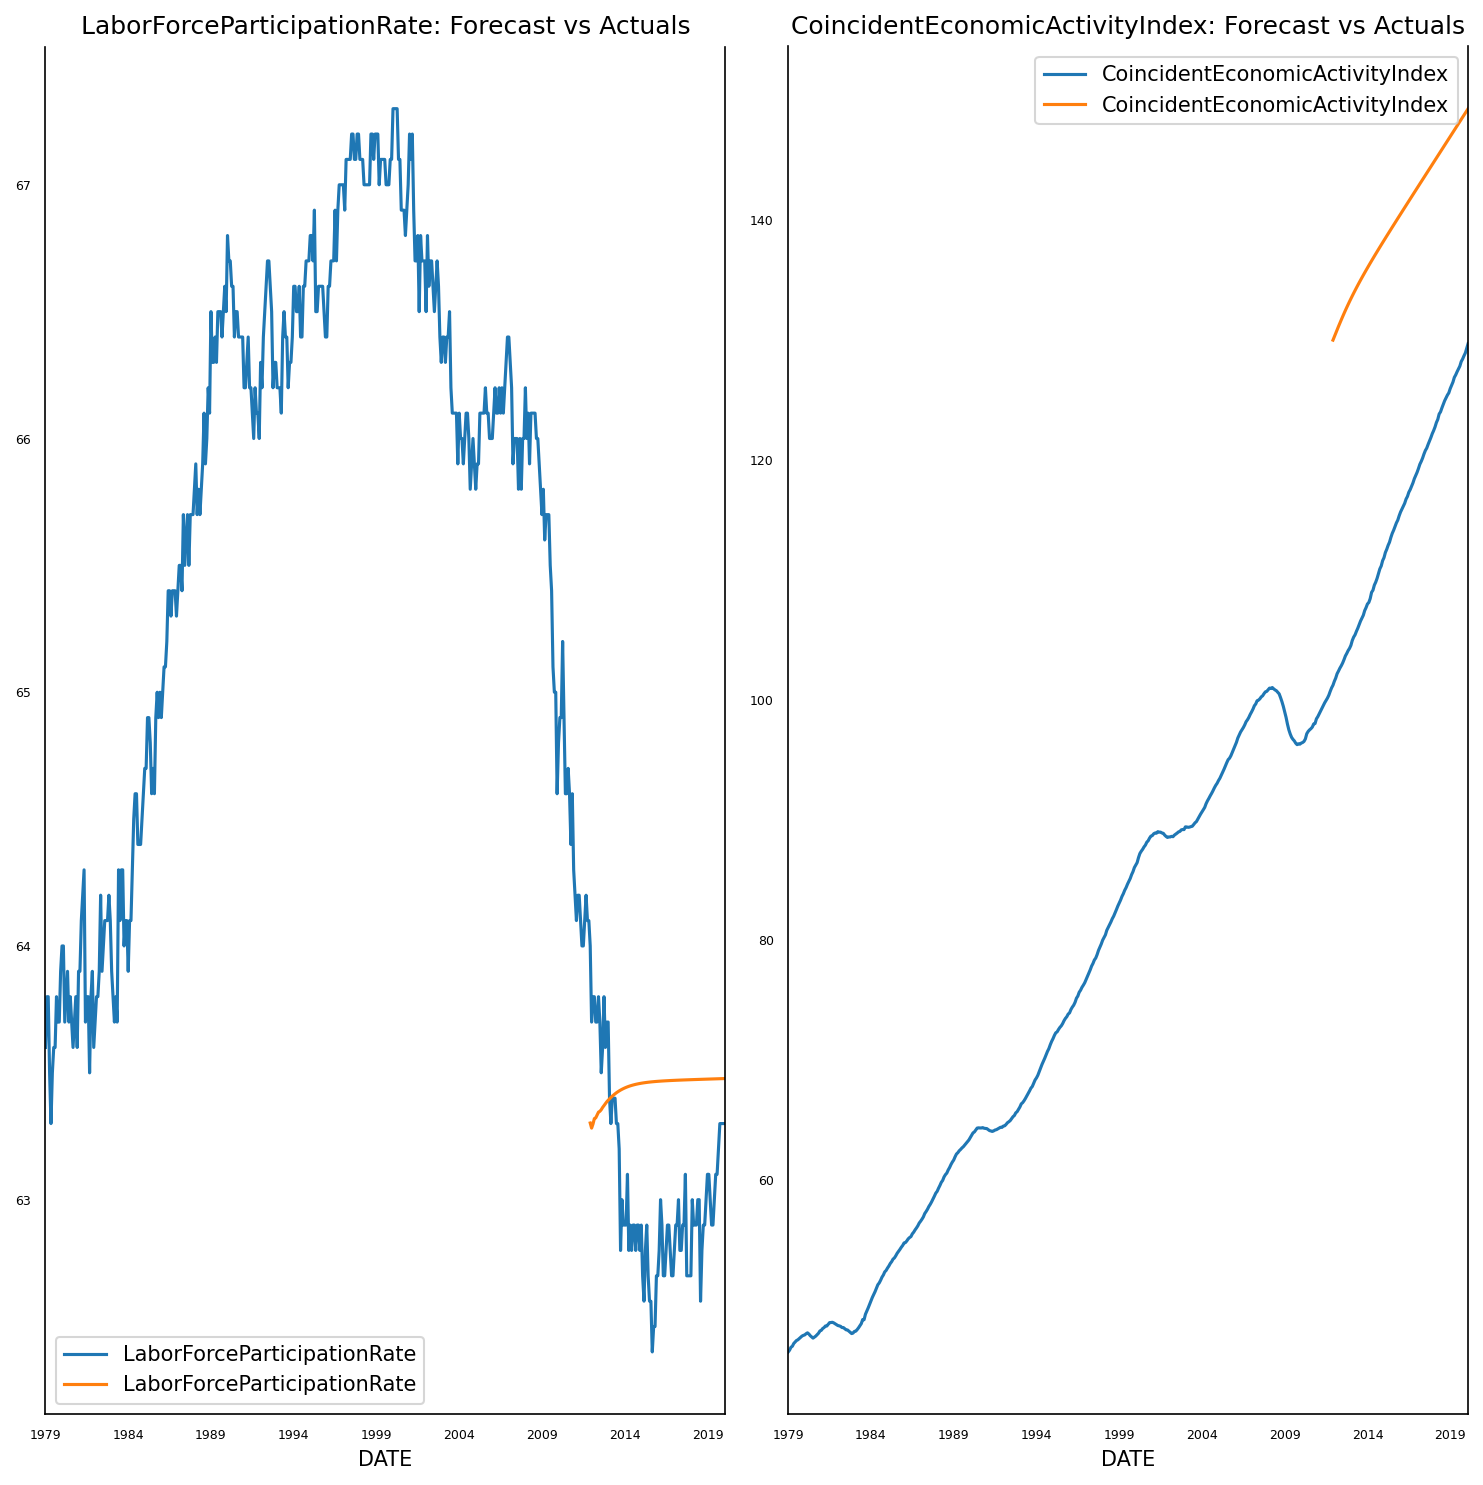

In [167]:
fig, axes = plt.subplots(nrows=int(len(df_var.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_var.columns, axes.flatten())):
    df_var[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_forecast[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### 13. Check residuals

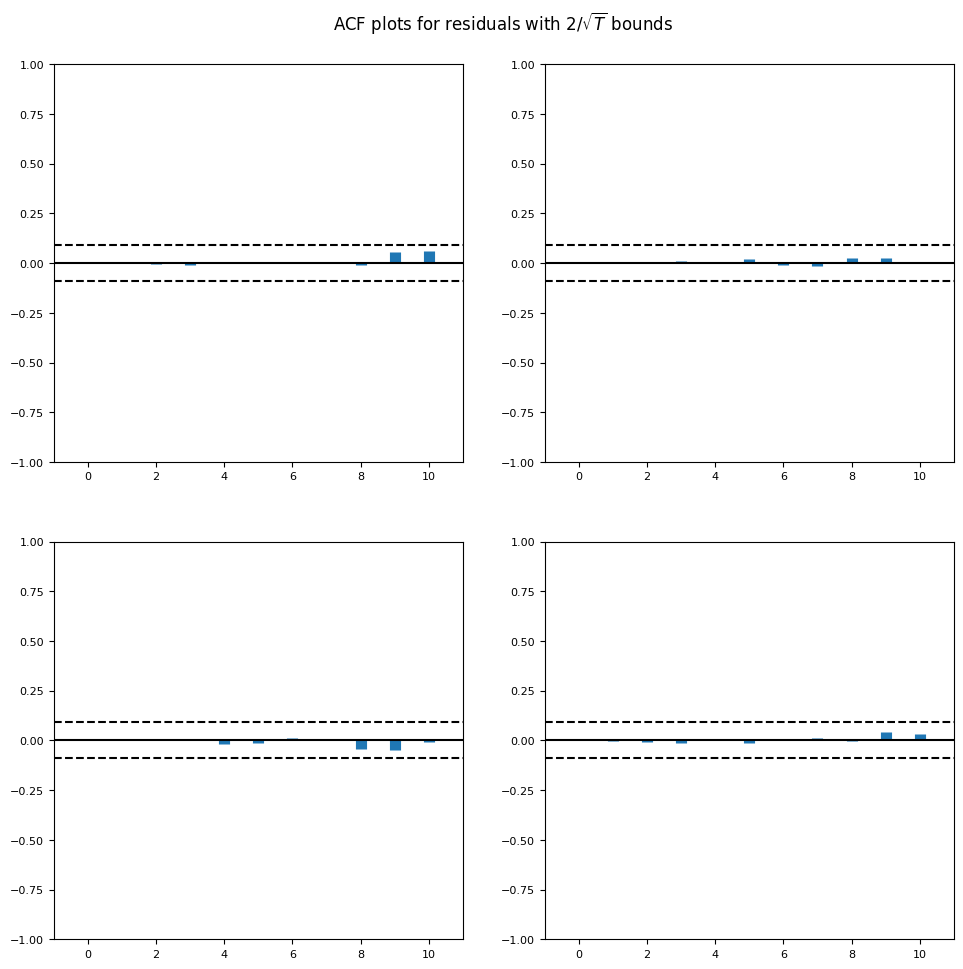

In [168]:
model_fitted.plot_acorr();

In [170]:
resid = model_fitted.resid

for col in resid.columns:
    ljung_box = sm.stats.acorr_ljungbox(resid[col])
    print(f'Ljung-Box for {col}:', ljung_box)


Ljung-Box for LaborForceParticipationRate:          lb_stat  lb_pvalue
1   2.714107e-08   0.999869
2   6.986362e-03   0.996513
3   6.595576e-02   0.995583
4   6.601266e-02   0.999467
5   6.835961e-02   0.999937
6   6.843338e-02   0.999993
7   7.110056e-02   0.999999
8   1.033221e-01   1.000000
9   1.771818e+00   0.994584
10  3.667045e+00   0.961120
Ljung-Box for CoincidentEconomicActivityIndex:      lb_stat  lb_pvalue
1   0.011880   0.913206
2   0.032112   0.984072
3   0.132429   0.987680
4   0.133684   0.997863
5   0.243474   0.998573
6   0.259649   0.999669
7   0.363201   0.999809
8   0.363623   0.999961
9   1.238236   0.998663
10  1.722143   0.998060


### 14. Assess model using IRF and FEVD

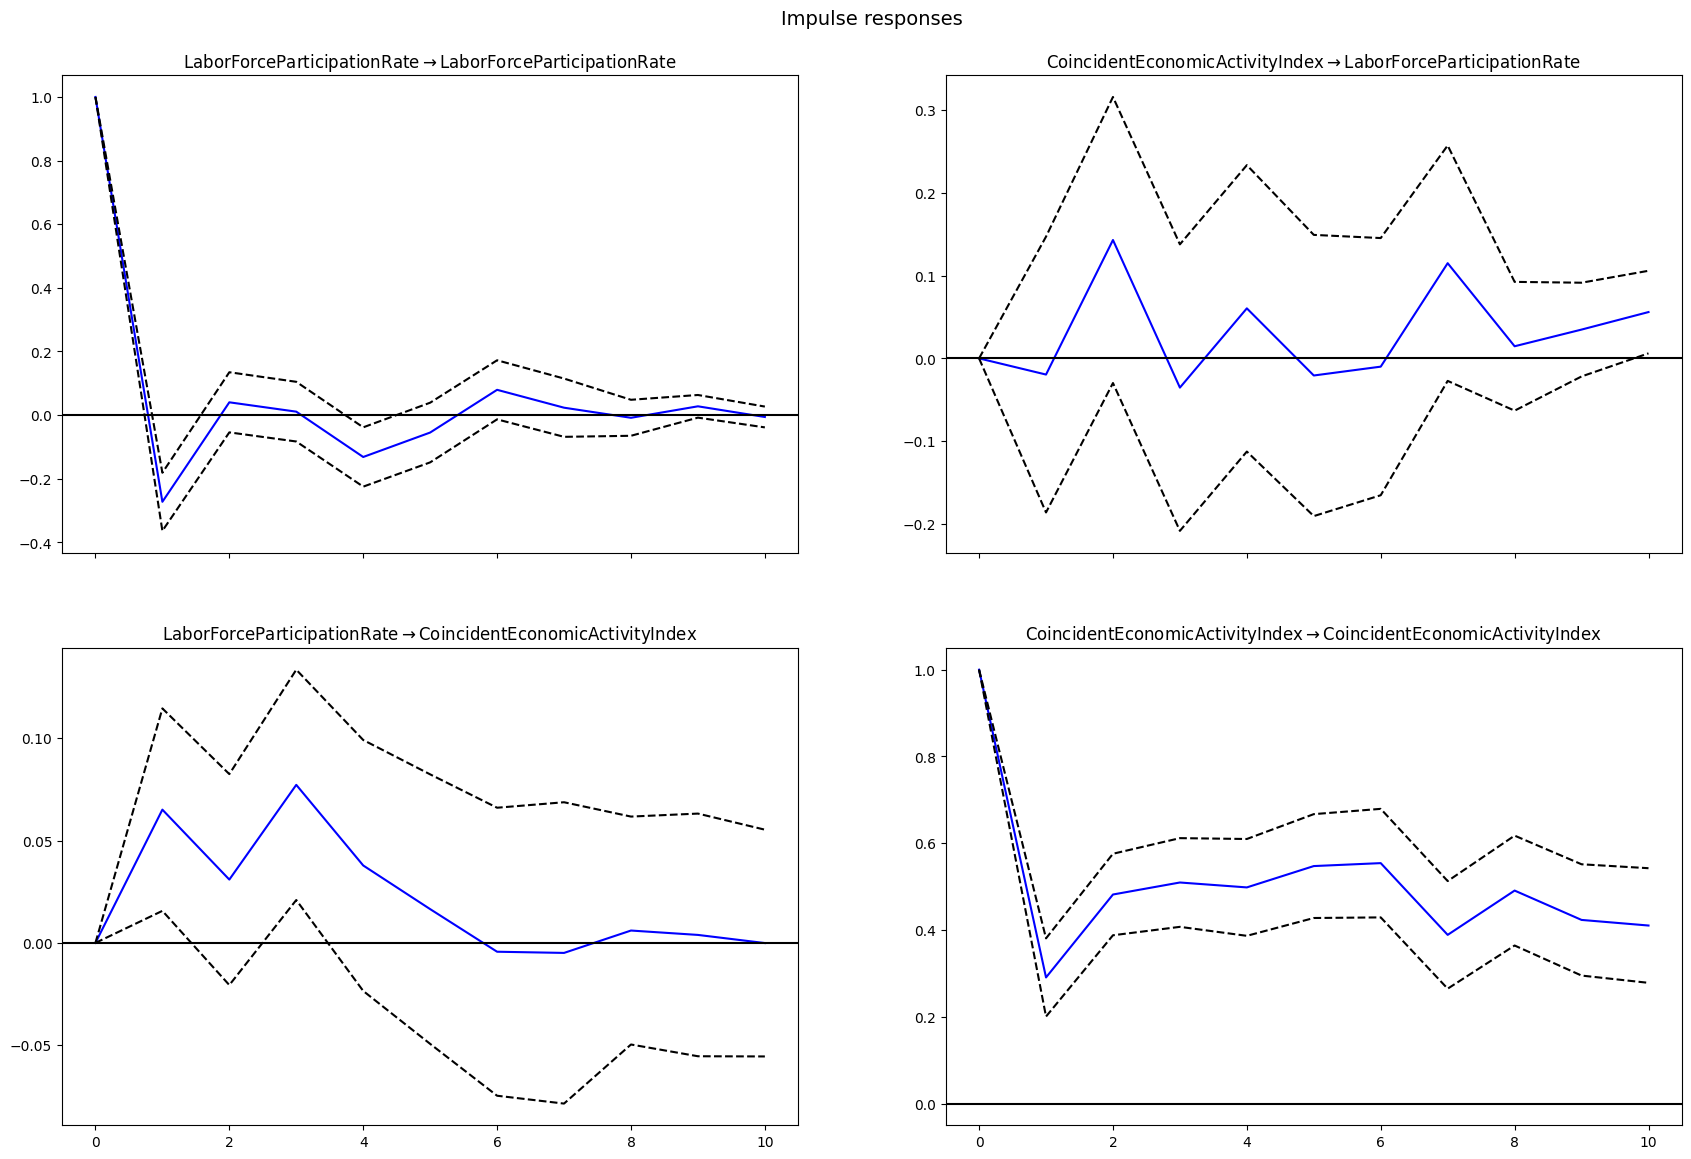

In [173]:
irf = model_fitted.irf(10)
irf.plot(orth=False, figsize=(18,12));

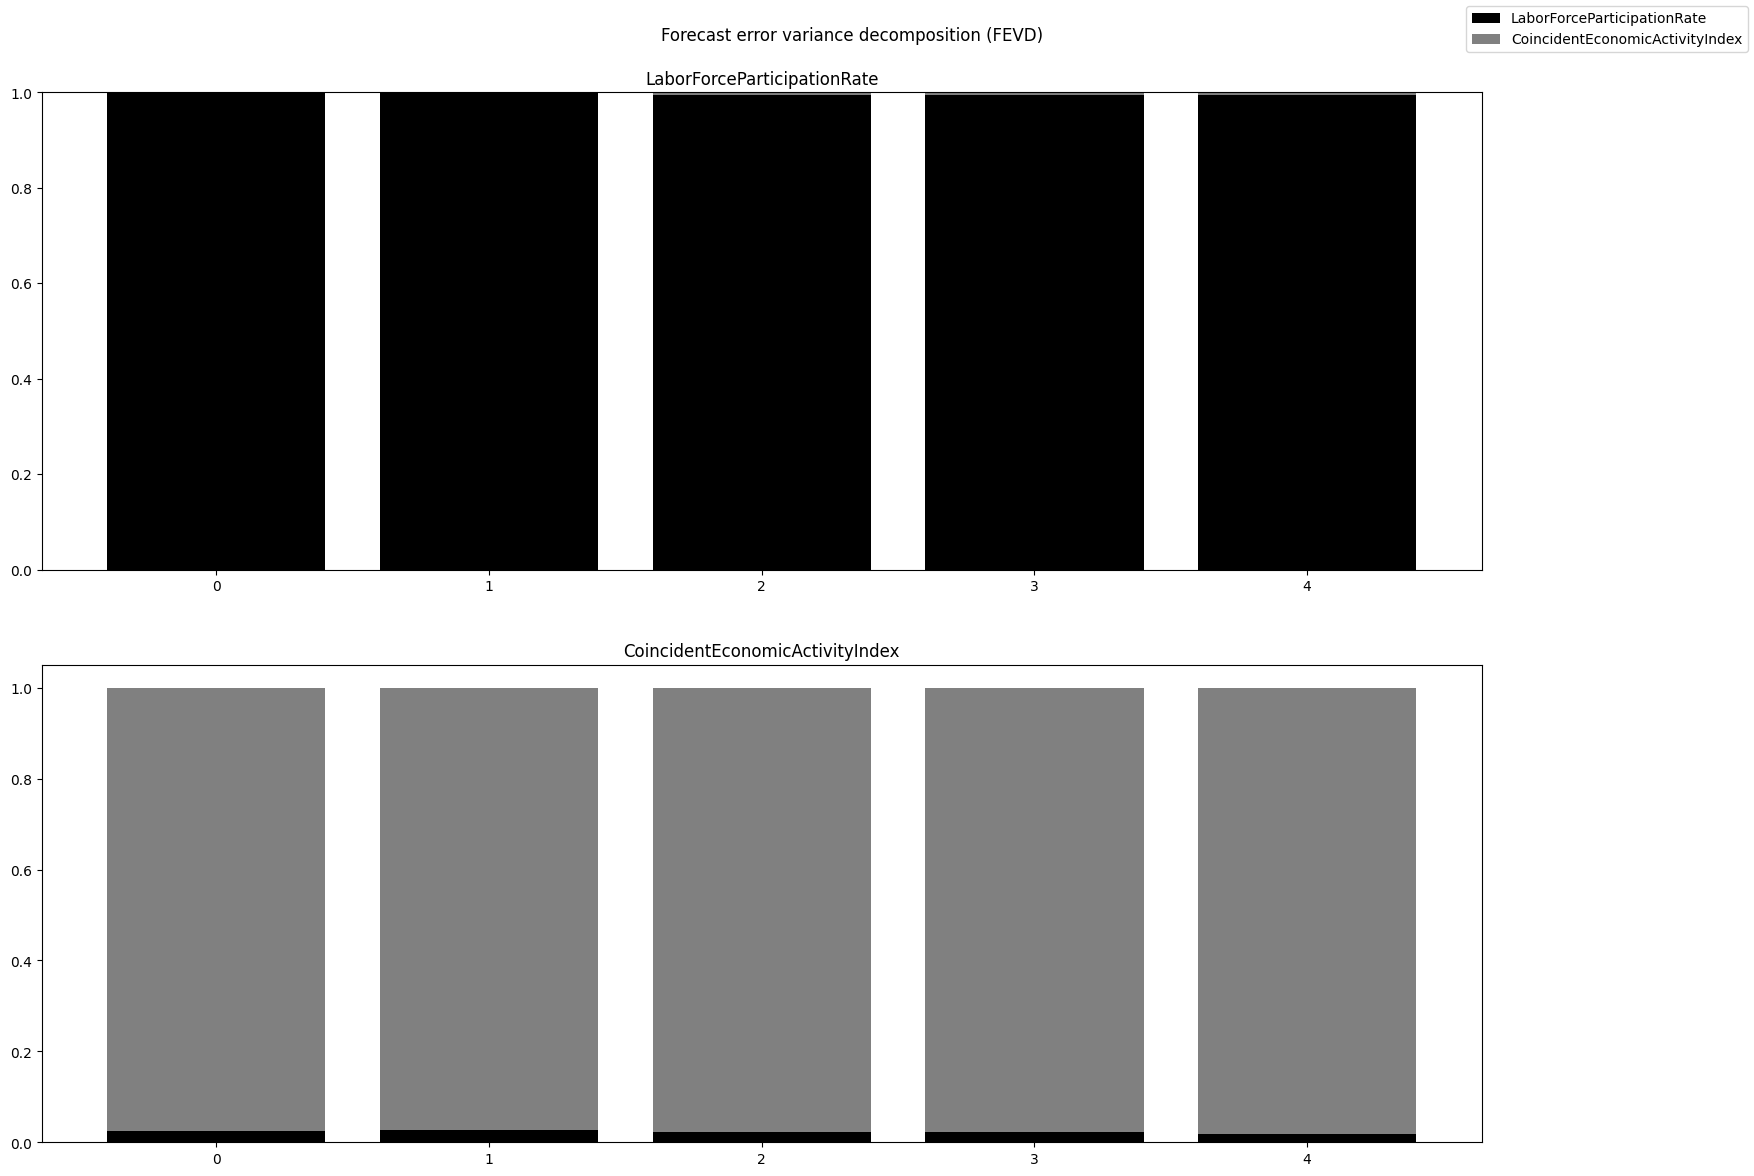

In [174]:
fevd = model_fitted.fevd(5)
fevd.plot(figsize=(18,12));

### 15. Evaluate model performance

In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
import numpy as np

for column in df_var.columns:
    mse = mean_squared_error(df_var.loc['2011-12-01':, column], df_forecast[column])
    print(f'MSE for {column}: {mse}')
print()

for column in df_var.columns:
    rmse = np.sqrt(mean_squared_error(df_var.loc['2011-12-01':, column], df_forecast[column]))
    print(f'RMSE for {column}: {rmse}')
print()

for column in df_var.columns:
    mae = mean_absolute_error(df_var.loc['2011-12-01':, column], df_forecast[column])
    print(f'MAE for {column}: {mae}')
print()

for column in df_var.columns:
    mape = np.mean(np.abs((df_var.loc['2011-12-01':, column] - df_forecast[column]) / df_var.loc['2011-12-01':, column])) * 100
    print(f'MAPE for {column}: {mape}')
print()

for column in df_var.columns:
    me = np.mean(df_var.loc['2011-12-01':, column] - df_forecast[column])
    print(f'ME for {column}: {me}')
print()

for column in df_var.columns:
    mpe = np.mean((df_var.loc['2011-12-01':, column] - df_forecast[column]) / df_var.loc['2011-12-01':, column]) * 100
    print(f'MPE for {column}: {mpe}')
print()

print(f"AIC of the model: {model_fitted.aic}")
print(f"BIC of the model: {model_fitted.bic}")

MSE for LaborForceParticipationRate: 0.32094954637395406
MSE for CoincidentEconomicActivityIndex: 629.4099958455416

RMSE for LaborForceParticipationRate: 0.5665240916094867
RMSE for CoincidentEconomicActivityIndex: 25.088044878896834

MAE for LaborForceParticipationRate: 0.5184024857514051
MAE for CoincidentEconomicActivityIndex: 24.904976492770405

MAPE for LaborForceParticipationRate: 0.823924571783283
MAPE for CoincidentEconomicActivityIndex: 21.893058375086714

ME for LaborForceParticipationRate: -0.4112052942862594
ME for CoincidentEconomicActivityIndex: -24.904976492770405

MPE for LaborForceParticipationRate: -0.6557989020183613
MPE for CoincidentEconomicActivityIndex: -21.893058375086714

AIC of the model: -9.182909020345258
BIC of the model: -8.924501080598315


In [180]:
def mean_directional_accuracy(actual, forecast):
    """
    Calculate Mean Directional Accuracy of the forecast.
    Parameters:
        actual (pd.Series or np.array): Array of actual values.
        forecast (pd.Series or np.array): Array of forecasted values.
    Returns:
        mda (float): Mean Directional Accuracy
    """
    actual_diff = np.diff(actual)
    forecast_diff = np.diff(forecast)
    directions_match = np.sign(actual_diff) == np.sign(forecast_diff)
    mda = directions_match.mean()
    return mda

In [181]:
for column in df_var.columns:
    mda = mean_directional_accuracy(df_var.loc['2011-12-01':, column].values, df_forecast[column].values)
    print(f'Mean Directional Accuracy for {column}: {mda}')

Mean Directional Accuracy for LaborForceParticipationRate: 0.3673469387755102
Mean Directional Accuracy for CoincidentEconomicActivityIndex: 1.0


In [182]:
def theil_u_statistic(actual, forecast):
    """
    Calculate Theil's U statistic.
    Parameters:
        actual (pd.Series or np.array): Array of actual values.
        forecast (pd.Series or np.array): Array of forecasted values.
    Returns:
        theil_u (float): Theil's U statistic
    """
    mse_forecast = mean_squared_error(actual, forecast)
    mse_naive = mean_squared_error(actual[1:], actual[:-1])
    theil_u = np.sqrt(mse_forecast / mse_naive)
    return theil_u

In [183]:
for column in df_var.columns:
    theil_u = theil_u_statistic(df_var.loc['2011-12-01':, column].values, df_forecast[column].values)
    print(f"Theil's U statistic for {column}: {theil_u}")

Theil's U statistic for LaborForceParticipationRate: 4.101196873996265
Theil's U statistic for CoincidentEconomicActivityIndex: 83.96593520093373


### 16. Compare results to a VARMA model

In [184]:
order.aic

7

In [185]:
varma_model = VARMAX(train, order=(order.aic, order.aic))
varma_model_fitted = varma_model.fit(disp=False)

In [186]:
varma_model_fitted.params

intercept.LaborForceParticipationRate                                   -0.020169
intercept.CoincidentEconomicActivityIndex                                0.016888
L1.LaborForceParticipationRate.LaborForceParticipationRate              -0.252533
L1.CoincidentEconomicActivityIndex.LaborForceParticipationRate          -0.005326
L2.LaborForceParticipationRate.LaborForceParticipationRate              -0.017926
                                                                           ...   
L7.e(LaborForceParticipationRate).CoincidentEconomicActivityIndex        0.030533
L7.e(CoincidentEconomicActivityIndex).CoincidentEconomicActivityIndex    0.070068
sqrt.var.LaborForceParticipationRate                                     0.133012
sqrt.cov.LaborForceParticipationRate.CoincidentEconomicActivityIndex    -0.008076
sqrt.var.CoincidentEconomicActivityIndex                                 0.070217
Length: 61, dtype: float64

In [187]:
varma_model_fitted.summary()

Dep. Variable:,"['LaborForceParticipationRate', 'CoincidentEconomicActivityIndex']",No. Observations:,394
Model:,"VARMA(7,7)",Log Likelihood,723.227
,+ intercept,AIC,-1324.455
Date:,"Sat, 10 Jun 2023",BIC,-1081.897
Time:,10:08:31,HQIC,-1228.342
Sample:,02-01-1979,,
,- 11-01-2011,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.03, 0.07",Jarque-Bera (JB):,"6.71, 7.79"
Prob(Q):,"0.87, 0.80",Prob(JB):,"0.03, 0.02"
Heteroskedasticity (H):,"0.86, 1.34",Skew:,"-0.14, -0.07"


In [188]:
varma_model_fitted.resid

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
DATE,,
1979-02-01,0.198123,0.004766
1979-03-01,0.047626,0.065620
1979-04-01,-0.301686,-0.114728
1979-05-01,-0.300326,0.088545
1979-06-01,0.157303,-0.010337
...,...,...
2011-07-01,-0.014689,-0.029723
2011-08-01,0.080368,0.012853
2011-09-01,0.060266,0.027927


In [189]:
out = durbin_watson(varma_model_fitted.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

LaborForceParticipationRate : 1.98
ConsumerPriceIndex : 2.02


### 17. Save results/forecasts of the VARMA model

In [192]:
varma_model_fitted.__dict__

{'_results': <statsmodels.tsa.statespace.varmax.VARMAXResults at 0x1e2ee691c90>,
 '__doc__': '\n    Class to hold results from fitting an VARMAX model.\n\n    Parameters\n    ----------\n    model : VARMAX instance\n        The fitted model instance\n\n    Attributes\n    ----------\n    specification : dictionary\n        Dictionary including all attributes from the VARMAX model instance.\n    coefficient_matrices_var : ndarray\n        Array containing autoregressive lag polynomial coefficient matrices,\n        ordered from lowest degree to highest.\n    coefficient_matrices_vma : ndarray\n        Array containing moving average lag polynomial coefficients,\n        ordered from lowest degree to highest.\n\n    See Also\n    --------\n    statsmodels.tsa.statespace.kalman_filter.FilterResults\n    statsmodels.tsa.statespace.mlemodel.MLEResults\n    ',
 'mlefit': <statsmodels.base.model.LikelihoodModelResults at 0x1e2ef61fe90>,
 'mle_retvals': {'fopt': -1.835602537881153,
  'gopt': a

In [200]:
lag_order = 7

forecast_input = train.values[-lag_order:]

fc_varma = varma_model_fitted.forecast(y=forecast_input, steps=len(test))

In [202]:
fc_varma

,LaborForceParticipationRate,CoincidentEconomicActivityIndex
2011-12-01,0.040861,0.277702
2012-01-01,0.008875,0.271436
2012-02-01,0.027221,0.275682
2012-03-01,0.046811,0.264233
2012-04-01,0.011453,0.264880
...,...,...
2019-10-01,0.001866,0.145136
2019-11-01,0.001865,0.145142
2019-12-01,0.001865,0.145147
2020-01-01,0.001864,0.145154


In [208]:
fc_varma.rename(
    columns = 
    {'LaborForceParticipationRate': 'LaborForceParticipationRate_VARMA'
     ,'CoincidentEconomicActivityIndex': 'CoincidentEconomicActivityIndex_VARMA' }
    , inplace=True
)

In [209]:
fc_varma

,LaborForceParticipationRate_VARMA,CoincidentEconomicActivityIndex_VARMA
2011-12-01,0.040861,0.277702
2012-01-01,0.008875,0.271436
2012-02-01,0.027221,0.275682
2012-03-01,0.046811,0.264233
2012-04-01,0.011453,0.264880
...,...,...
2019-10-01,0.001866,0.145136
2019-11-01,0.001865,0.145142
2019-12-01,0.001865,0.145147
2020-01-01,0.001864,0.145154


In [210]:
df_forecast_varma = fc_varma

In [211]:
df_forecast_varma['LaborForceParticipationRate_inv'] = df_var['LaborForceParticipationRate'].iloc[-1] + df_forecast_varma['LaborForceParticipationRate_VARMA'].cumsum()
df_forecast_varma['CoincidentEconomicActivityIndex_inv'] = df_var['CoincidentEconomicActivityIndex'].iloc[-1] + df_forecast_varma['CoincidentEconomicActivityIndex_VARMA'].cumsum()

In [212]:
df_forecast_varma

,LaborForceParticipationRate_VARMA,CoincidentEconomicActivityIndex_VARMA,LaborForceParticipationRate_inv,CoincidentEconomicActivityIndex_inv
2011-12-01,0.040861,0.277702,63.340861,129.977702
2012-01-01,0.008875,0.271436,63.349736,130.249139
2012-02-01,0.027221,0.275682,63.376957,130.524820
2012-03-01,0.046811,0.264233,63.423768,130.789053
2012-04-01,0.011453,0.264880,63.435222,131.053933
...,...,...,...,...
2019-10-01,0.001866,0.145136,63.801477,144.711587
2019-11-01,0.001865,0.145142,63.803343,144.856728
2019-12-01,0.001865,0.145147,63.805207,145.001876
2020-01-01,0.001864,0.145154,63.807072,145.147029


In [214]:
df_forecast_varma.rename(
    columns = 
    {'LaborForceParticipationRate_inv': 'LaborForceParticipationRate_VARMA_inv'
     ,'CoincidentEconomicActivityIndex_inv': 'CoincidentEconomicActivityIndex_VARMA_inv'}
    , inplace=True
)

In [215]:
df_forecast.rename(
    columns = 
    {'LaborForceParticipationRate': 'LaborForceParticipationRate_VAR_inv'
     ,'CoincidentEconomicActivityIndex': 'CoincidentEconomicActivityIndex_VAR_inv'
     ,'LaborForceParticipationRate_2d': 'LaborForceParticipationRate_VAR'
     ,'CoincidentEconomicActivityIndex_2d': 'CoincidentEconomicActivityIndex_VAR'}
    , inplace=True
)

In [216]:
df_forecast_varma.head()

,LaborForceParticipationRate_VARMA,CoincidentEconomicActivityIndex_VARMA,LaborForceParticipationRate_VARMA_inv,CoincidentEconomicActivityIndex_VARMA_inv
2011-12-01,0.040861,0.277702,63.340861,129.977702
2012-01-01,0.008875,0.271436,63.349736,130.249139
2012-02-01,0.027221,0.275682,63.376957,130.524820
2012-03-01,0.046811,0.264233,63.423768,130.789053
2012-04-01,0.011453,0.264880,63.435222,131.053933


In [217]:
df_forecast_var = df_forecast

In [219]:
df_forecast_var.head()

,LaborForceParticipationRate_VAR,CoincidentEconomicActivityIndex_VAR,LaborForceParticipationRate_VAR_inv,CoincidentEconomicActivityIndex_VAR_inv
DATE,,,,
2011-12-01,0.002273,0.286681,63.302273,129.986681
2012-01-01,-0.020181,0.283789,63.282092,130.270469
2012-02-01,0.015688,0.283478,63.297779,130.553947
2012-03-01,0.021700,0.285747,63.319479,130.839694
2012-04-01,0.002886,0.285268,63.322366,131.124962


In [220]:
df_comparison = df_forecast_var.drop(columns=['LaborForceParticipationRate_VAR', 'CoincidentEconomicActivityIndex_VAR'])

In [221]:
df_comparison.head()

,LaborForceParticipationRate_VAR_inv,CoincidentEconomicActivityIndex_VAR_inv
DATE,,
2011-12-01,63.302273,129.986681
2012-01-01,63.282092,130.270469
2012-02-01,63.297779,130.553947
2012-03-01,63.319479,130.839694
2012-04-01,63.322366,131.124962


In [222]:
df_comparison['LaborForceParticipationRate_VARMA_inv'] = df_forecast_varma['LaborForceParticipationRate_VARMA_inv']
df_comparison['CoincidentEconomicActivityIndex_VARMA_inv'] = df_forecast_varma['CoincidentEconomicActivityIndex_VARMA_inv']

In [223]:
df_comparison

,LaborForceParticipationRate_VAR_inv,CoincidentEconomicActivityIndex_VAR_inv,LaborForceParticipationRate_VARMA_inv,CoincidentEconomicActivityIndex_VARMA_inv
DATE,,,,
2011-12-01,63.302273,129.986681,63.340861,129.977702
2012-01-01,63.282092,130.270469,63.349736,130.249139
2012-02-01,63.297779,130.553947,63.376957,130.524820
2012-03-01,63.319479,130.839694,63.423768,130.789053
2012-04-01,63.322366,131.124962,63.435222,131.053933
...,...,...,...,...
2019-10-01,63.476766,148.557419,63.801477,144.711587
2019-11-01,63.476940,148.736271,63.803343,144.856728
2019-12-01,63.477115,148.915121,63.805207,145.001876


### 18. Check VARMA forecast

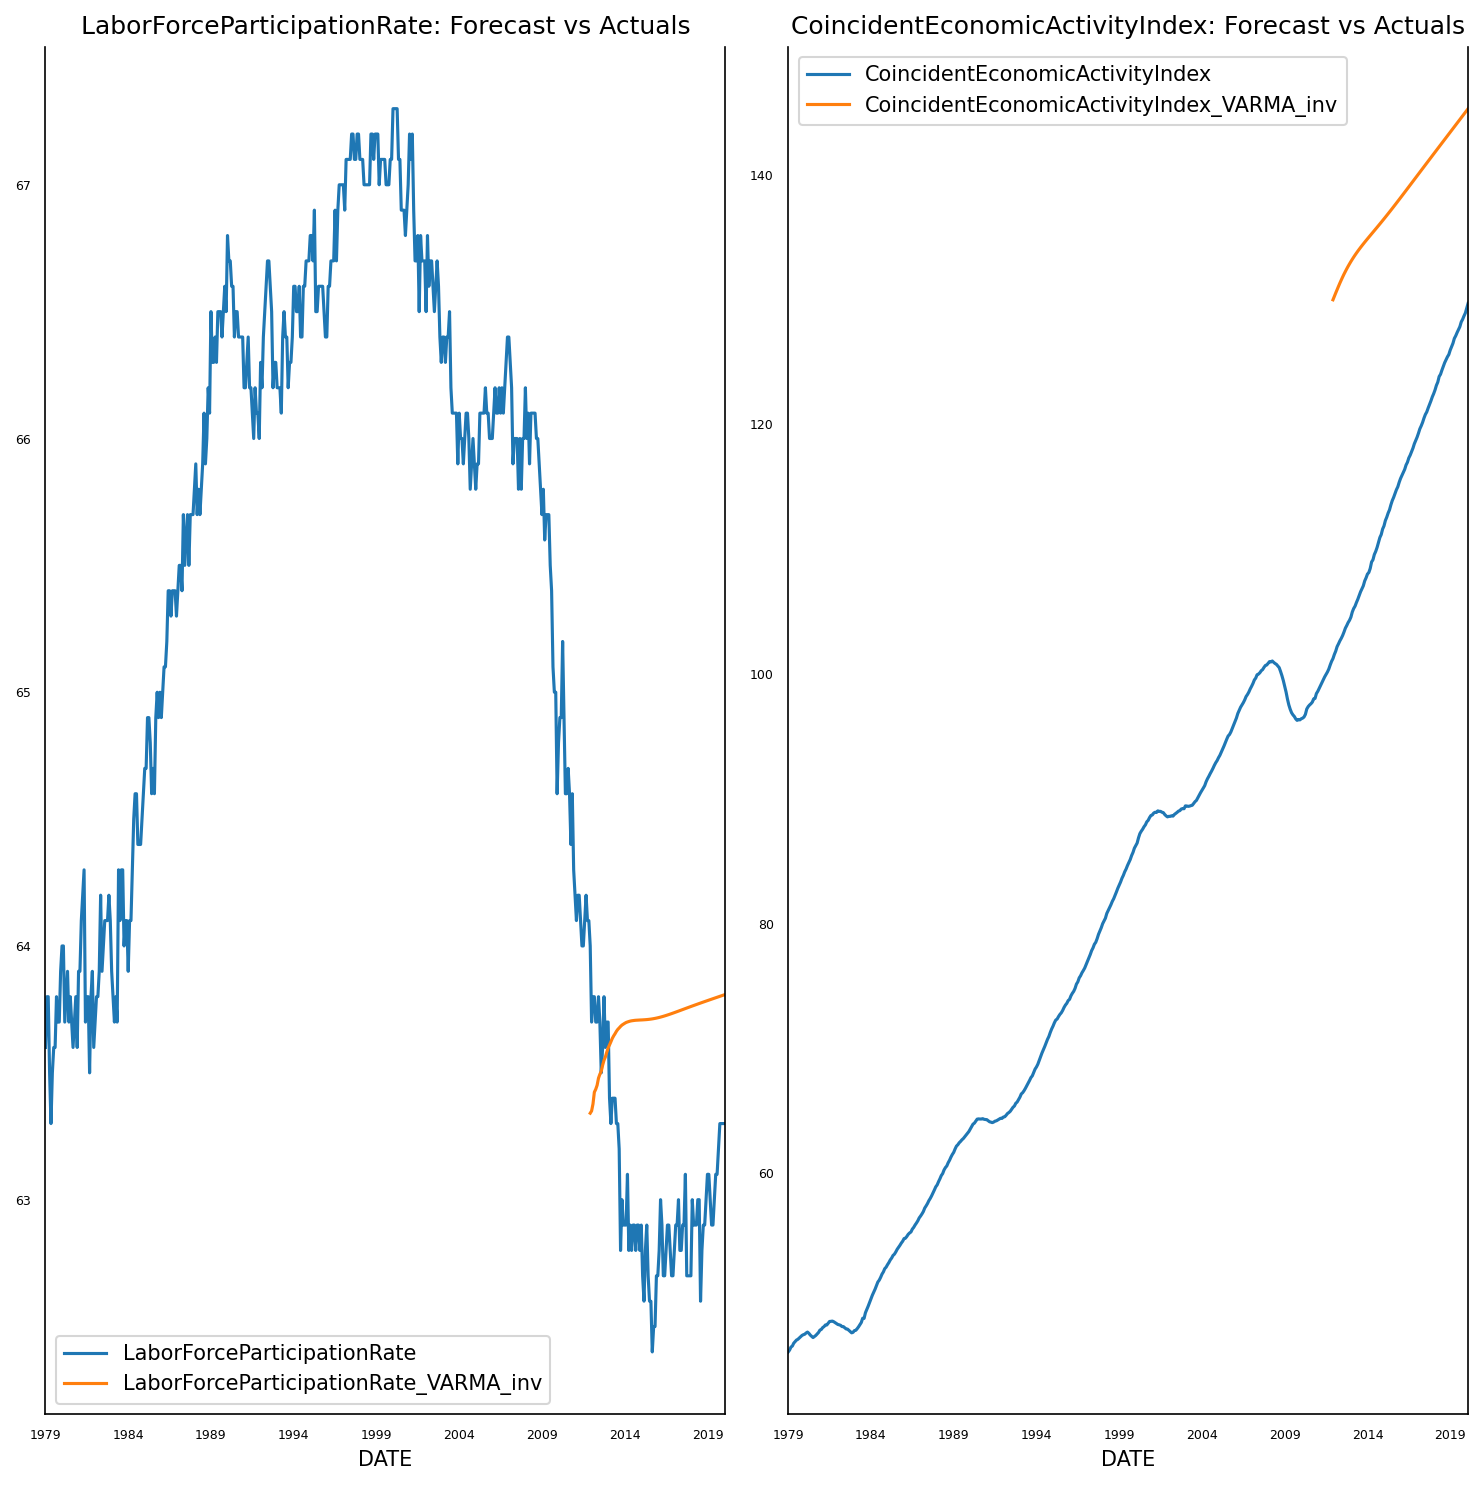

In [224]:
fig, axes = plt.subplots(nrows=int(len(df_var.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df_var.columns, axes.flatten())):
    df_var[col].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df_comparison[col+'_VARMA_inv'].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### 19. Check VARMA residuals

In [225]:
resid = varma_model_fitted.resid

for col in resid.columns:
    ljung_box = sm.stats.acorr_ljungbox(resid[col])
    print(f'Ljung-Box for {col}:', ljung_box)

Ljung-Box for LaborForceParticipationRate:      lb_stat  lb_pvalue
1   0.029079   0.864596
2   0.205380   0.902406
3   0.217423   0.974729
4   0.330789   0.987741
5   0.376520   0.995952
6   0.377441   0.999027
7   0.384664   0.999769
8   0.497148   0.999869
9   1.272495   0.998509
10  1.746585   0.997939
Ljung-Box for CoincidentEconomicActivityIndex:      lb_stat  lb_pvalue
1   0.043800   0.834225
2   0.056510   0.972140
3   0.063553   0.995819
4   0.066628   0.999457
5   0.078434   0.999911
6   0.839319   0.990978
7   0.841495   0.996997
8   0.843220   0.999058
9   2.742048   0.973650
10  2.771864   0.986295


### 20. Check VARMA metrics

In [226]:
for column in df_var.columns:
    mse = mean_squared_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv'])
    print(f'MSE for {column}: {mse}')
print()

for column in df_var.columns:
    rmse = np.sqrt(mean_squared_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv']))
    print(f'RMSE for {column}: {rmse}')
print()

for column in df_var.columns:
    mae = mean_absolute_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv'])
    print(f'MAE for {column}: {mae}')
print()

for column in df_var.columns:
    mape = np.mean(np.abs((df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv']) / df_var.loc['2011-12-01':, column])) * 100
    print(f'MAPE for {column}: {mape}')
print()

for column in df_var.columns:
    me = np.mean(df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv'])
    print(f'ME for {column}: {me}')
print()

for column in df_var.columns:
    mpe = np.mean((df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv']) / df_var.loc['2011-12-01':, column]) * 100
    print(f'MPE for {column}: {mpe}')
print()

print(f"AIC of the VARMA model: {varma_model_fitted.aic}")
print(f"BIC of the VARMA model: {varma_model_fitted.bic}")

MSE for LaborForceParticipationRate: 0.626243083106546
MSE for CoincidentEconomicActivityIndex: 536.4899840202625

RMSE for LaborForceParticipationRate: 0.7913552192957003
RMSE for CoincidentEconomicActivityIndex: 23.16225343139701

MAE for LaborForceParticipationRate: 0.7329799140241102
MAE for CoincidentEconomicActivityIndex: 22.77399198126714

MAPE for LaborForceParticipationRate: 1.1653007243454243
MAPE for CoincidentEconomicActivityIndex: 20.113835749143053

ME for LaborForceParticipationRate: -0.6637348722198593
ME for CoincidentEconomicActivityIndex: -22.77399198126714

MPE for LaborForceParticipationRate: -1.0567565644359007
MPE for CoincidentEconomicActivityIndex: -20.113835749143053

AIC of the VARMA model: -1324.4547998503485
BIC of the VARMA model: -1081.8973943831745


In [228]:
for column in df_var.columns:
    mda = mean_directional_accuracy(df_var.loc['2011-12-01':, column].values, df_comparison[column+'_VARMA_inv'].values)
    print(f'Mean Directional Accuracy for {column}: {mda}')
print()

for column in df_var.columns:
    theil_u = theil_u_statistic(df_var.loc['2011-12-01':, column].values, df_comparison[column+'_VARMA_inv'].values)
    print(f"Theil's U statistic for {column}: {theil_u}")

Mean Directional Accuracy for LaborForceParticipationRate: 0.35714285714285715
Mean Directional Accuracy for CoincidentEconomicActivityIndex: 1.0

Theil's U statistic for LaborForceParticipationRate: 5.7288005923556184
Theil's U statistic for CoincidentEconomicActivityIndex: 77.52059915853452


### 21. Compare metrics between VAR and VARMA models

In [230]:
from collections import defaultdict

metrics = defaultdict(dict)

for column in df_var.columns:

    metrics['VAR'][f'{column}_MSE'] = mean_squared_error(df_var.loc['2011-12-01':, column], df_forecast[column+'_VAR_inv'])
    metrics['VAR'][f'{column}_RMSE'] = np.sqrt(mean_squared_error(df_var.loc['2011-12-01':, column], df_forecast[column+'_VAR_inv']))
    metrics['VAR'][f'{column}_MAE'] = mean_absolute_error(df_var.loc['2011-12-01':, column], df_forecast[column+'_VAR_inv'])
    metrics['VAR'][f'{column}_MAPE'] = np.mean(np.abs((df_var.loc['2011-12-01':, column] - df_forecast[column+'_VAR_inv']) / df_var.loc['2011-12-01':, column])) * 100
    metrics['VAR'][f'{column}_ME'] = np.mean(df_var.loc['2011-12-01':, column] - df_forecast[column+'_VAR_inv'])
    metrics['VAR'][f'{column}_MPE'] = np.mean((df_var.loc['2011-12-01':, column] - df_forecast[column+'_VAR_inv']) / df_var.loc['2011-12-01':, column]) * 100
    metrics['VAR'][f'{column}_MDA'] = mean_directional_accuracy(df_var.loc['2011-12-01':, column].values, df_forecast[column+'_VAR_inv'].values)
    metrics['VAR'][f'{column}_Theil_U'] = theil_u_statistic(df_var.loc['2011-12-01':, column].values, df_forecast[column+'_VAR_inv'].values)

    metrics['VARMA'][f'{column}_MSE'] = mean_squared_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv'])
    metrics['VARMA'][f'{column}_RMSE'] = np.sqrt(mean_squared_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv']))
    metrics['VARMA'][f'{column}_MAE'] = mean_absolute_error(df_var.loc['2011-12-01':, column], df_comparison[column+'_VARMA_inv'])
    metrics['VARMA'][f'{column}_MAPE'] = np.mean(np.abs((df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv']) / df_var.loc['2011-12-01':, column])) * 100
    metrics['VARMA'][f'{column}_ME'] = np.mean(df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv'])
    metrics['VARMA'][f'{column}_MPE'] = np.mean((df_var.loc['2011-12-01':, column] - df_comparison[column+'_VARMA_inv']) / df_var.loc['2011-12-01':, column]) * 100
    metrics['VARMA'][f'{column}_MDA'] = mean_directional_accuracy(df_var.loc['2011-12-01':, column].values, df_comparison[column+'_VARMA_inv'].values)
    metrics['VARMA'][f'{column}_Theil_U'] = theil_u_statistic(df_var.loc['2011-12-01':, column].values, df_comparison[column+'_VARMA_inv'].values)

metrics['VAR']['AIC'] = model_fitted.aic
metrics['VAR']['BIC'] = model_fitted.bic
metrics['VARMA']['AIC'] = varma_model_fitted.aic
metrics['VARMA']['BIC'] = varma_model_fitted.bic

df_metrics = pd.DataFrame(metrics)

In [231]:
df_metrics

,VAR,VARMA
LaborForceParticipationRate_MSE,0.320950,0.626243
LaborForceParticipationRate_RMSE,0.566524,0.791355
LaborForceParticipationRate_MAE,0.518402,0.732980
LaborForceParticipationRate_MAPE,0.823925,1.165301
LaborForceParticipationRate_ME,-0.411205,-0.663735
LaborForceParticipationRate_MPE,-0.655799,-1.056757
LaborForceParticipationRate_MDA,0.367347,0.357143
LaborForceParticipationRate_Theil_U,4.101197,5.728801
CoincidentEconomicActivityIndex_MSE,629.409996,536.489984
CoincidentEconomicActivityIndex_RMSE,25.088045,23.162253
